In [2]:
import torch
import torch.nn as nn
import math
import time
import torch.nn.functional as F

In [3]:
# Setting up device configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is: ", device)

Device is:  cuda


In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2") # Load the GPT-2 tokenize

In [5]:
tokenizer.n_vocab

50257

In [6]:
# Downloading the Data -> Here we are using tiny shakespeare dataset from github
!wget https://github.com/Deevanshik/GPT-from-Scratch/blob/main/data.txt
with open('/kaggle/working/data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2025-05-28 13:53:13--  https://github.com/Deevanshik/GPT-from-Scratch/blob/main/data.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.txt’

data.txt                [  <=>               ]   1.09M  5.02MB/s    in 0.2s    

2025-05-28 13:53:14 (5.02 MB/s) - ‘data.txt’ saved [1140903]



In [7]:
data = torch.tensor(tokenizer.encode(text), dtype = torch.int64)
print(data.shape, data.dtype)
print(data[:10])
# Train and Validation Split
n = int(0.9*(len(data)))
train_data = data[:n]
val_data = data[n:]
vocab_size = tokenizer.n_vocab

torch.Size([345172]) torch.int64
tensor([  628,   628,   198,   198,    27,     0, 18227,  4177,    56, 11401])


In [8]:
VANILLA_GPT_CONFIG = {
    "vocab_size": vocab_size,    # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 384,         # Embedding dimension
    "proj_dim" : 384  ,     # Projected sequence length
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "use_mask" : True,
    "batch_size": 16,
    "lr": 10**-5,
    "sharing": None
}

In [9]:
# headwise sharing
HW_LINEAR_GPT_CONFIG = {
    "vocab_size": vocab_size,    # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 384,         # Embedding dimension
    "proj_dim" : 64  ,     # Projected sequence length
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "use_mask" : True,
    "batch_size": 16,
    "lr": 10**-5,
    "sharing": "headwise-sharing"
}

In [10]:
KV_LINEAR_GPT_CONFIG = {
    "vocab_size": vocab_size,    # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 384,         # Embedding dimension
    "proj_dim" : 64  ,     # Projected sequence length
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "use_mask" : True,
    "batch_size": 16,
    "lr": 10**-5,
    "sharing": "key-value-sharing"
}

In [11]:
LW_LINEAR_GPT_CONFIG = {
    "vocab_size": vocab_size,    # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 384,         # Embedding dimension
    "proj_dim" : 64  ,     # Projected sequence length
    "n_heads": 6,          # Number of attention heads
    "n_layers": 6,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "use_mask" : True,
    "batch_size": 16,
    "lr": 10**-5,
    "sharing": "layerwise-sharing"
}

In [12]:
# Embedding class
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_seq_length, padding_idx):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.pos_embed = nn.Embedding(max_seq_length, embed_size)

    def forward(self, x):
        B, T = x.shape
        emb = self.embed(x)  # (B, T, C)
        positions = torch.arange(T, device=device)
        pos_emb = self.pos_embed(positions).unsqueeze(0).expand(B,T, -1) # (B, T, C)
        # Creating a padding mask to set padding tokens to all zero
        padding_mask = (x == self.embed.padding_idx).unsqueeze(-1)  # (B, T, 1)
        pos_emb = pos_emb.masked_fill(padding_mask, 0)
        return emb+pos_emb

In [13]:
import torch.nn.functional as F
def generate_causal_mask(seq_length, proj_dim):
    mask = torch.tril(torch.ones(seq_length, proj_dim, dtype=torch.int))
    return mask.unsqueeze(0).unsqueeze(0)

In [14]:
def generate_padding_mask(context_length, seq_length, proj_dim):
    # Create a mask of zeros
    mask = torch.zeros(context_length, proj_dim, dtype=torch.int)
    
    # Set first `seq_length` rows to 1
    mask[:seq_length, :] = 1
    
    return mask.unsqueeze(0).unsqueeze(0)

In [15]:
# 3. Multi-Head Attention 
class MultiHeadLinearAttention(nn.Module):
    def __init__(self, embed_size, num_heads, proj_dim, seq_len, sharing, proj, qkv_bias=False, layer_idx=None):
        super().__init__()
        self.embed_size = embed_size # -> d
        self.num_heads = num_heads # -> h
        self.head_dim = embed_size // num_heads # -> d/h
        self.proj_dim = proj_dim  # -> k
        self.seq_len = seq_len # -> N
        self.sharing = sharing
        self.layer_idx = layer_idx
        self.proj = proj
        
        self.query = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        self.key = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        self.value = nn.Linear(embed_size, embed_size, bias=qkv_bias) # d*d
        
        self.out = nn.Linear(embed_size, embed_size) # fully connected FFNN from d -> d
        
    def forward(self, x, use_mask=False):
        B, T, _ = x.shape # Batch size, Sequence Length, Embed size
        h = self.num_heads
        d_h = self.head_dim
        N = self.seq_len
        
        q = self.query(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2) # (B, N, d) → (B, N, h, d/h) -> (B, h, N, d/h)
        k = self.key(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        

        if(self.sharing == "layerwise-sharing"):
            # layerwise sharing 
            projn_matrix = self.proj
            projn_matrix = projn_matrix.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix@k
            v_proj = projn_matrix@v
        elif(self.sharing == "key-value-sharing"):
            # key-value sharing
            projn_matrix = self.proj[self.layer_idx]
            projn_matrix = projn_matrix.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix@k
            v_proj = projn_matrix@v
        elif(self.sharing == "headwise-sharing"):
            # headwise sharing
            projn_matrix_E = self.proj["E"][self.layer_idx]
            projn_matrix_F = self.proj["F"][self.layer_idx]
            projn_matrix_E = projn_matrix_E.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            projn_matrix_F = projn_matrix_F.unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            k_proj = projn_matrix_E@k
            v_proj = projn_matrix_F@v
        elif(self.sharing == None):
            k_proj = k
            v_proj = v
            
        attention = (q@(k_proj.transpose(-1, -2))) / math.sqrt(self.head_dim) # (B, h, N, k)
        if (use_mask):
            if(self.sharing == None):
                causal_mask = generate_causal_mask(T, T) # (1,1,T,T)
                padding_mask = generate_padding_mask(self.seq_len, T, T) # (1,1,T,T)
            else:
                causal_mask = generate_causal_mask(T, self.proj_dim) # (1,1,T,k)
                padding_mask = generate_padding_mask(self.seq_len, T, self.proj_dim) # (1,1,T,k)
            mask = causal_mask&padding_mask
            mask = mask.to(device)
            attention = attention.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(attention, dim=-1)
        attention = torch.nan_to_num(attention, nan=0.0) # (B,h,N,k)
        
        out = attention@v_proj
        out = out.transpose(1, 2).contiguous().view(B, -1, self.embed_size)
        return self.out(out)

In [16]:
# 5. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size):
        super().__init__()
        # First linear layer that transforms input from embedding size to hidden size
        self.fc1 = nn.Linear(embed_size, ff_hidden_size)
        # Second linear layer that transforms from hidden size back to embedding size
        self.fc2 = nn.Linear(ff_hidden_size, embed_size)
        # GELU activation function
        self.gelu = nn.GELU()
    def forward(self, x):
        # Forward pass: apply the first linear layer, then GELU activation, and finally the second linear layer
        return self.fc2(self.gelu(self.fc1(x)))

In [17]:
def projection(sharing, seq_length, proj_dim, n_layers=None, device=None):
    if sharing == "layerwise-sharing":
        proj = nn.Parameter(torch.empty(seq_length, proj_dim).to(device))
        torch.nn.init.xavier_normal_(proj)
        return proj

    elif sharing == "key-value-sharing":
        proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        for proj_i in proj:
            torch.nn.init.xavier_normal_(proj_i)
        return proj

    elif sharing == "headwise-sharing":
        E_proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        F_proj = [nn.Parameter(torch.empty(seq_length, proj_dim).to(device)) for _ in range(n_layers)]
        for proj_i in E_proj:
            torch.nn.init.xavier_normal_(proj_i)
        for proj_i in F_proj:
            torch.nn.init.xavier_normal_(proj_i)
        proj_dict = {
            "E": E_proj,
            "F": F_proj
        }
        return proj_dict

In [18]:
# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, ff_hidden_size, proj_dim, seq_len, sharing, proj, dropout=0.1, qkv_bias=False, layer_idx=None):
        super().__init__()
        # Layer norm before attention
        self.ln1 = nn.LayerNorm(embed_size)
        # Multi-Head Self-Attention
        self.mha = MultiHeadLinearAttention(embed_size, num_heads, proj_dim, seq_len, sharing, proj, qkv_bias=qkv_bias, layer_idx=layer_idx)
        self.dropout1 = nn.Dropout(dropout)

        # Layer norm before FFN
        self.ln2 = nn.LayerNorm(embed_size)
        self.ff = FeedForward(embed_size, ff_hidden_size)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, use_mask=False):
        # MHA with Layer norm and residual connection
        x = x + self.dropout1(self.mha(self.ln1(x), use_mask))
        # FFN with layer norm and residual connection
        x = x + self.dropout2(self.ff(self.ln2(x)))
        return x

In [19]:
def right_pad_input(input_ids, context_length, pad_token_id=-1):
    B,T = input_ids.shape
    if T < context_length:
        padding = torch.full((B, context_length - T), pad_token_id, dtype=input_ids.dtype, device=input_ids.device)
        input_ids_padded = torch.cat([input_ids, padding], dim=1)
    else:
        input_ids_padded = input_ids[:, :context_length]
    return input_ids_padded

In [20]:
# 7. GPT-2 Model
class GPT2_modified(nn.Module):
    def __init__(self, config, seq_len):
        super().__init__()
        # Initializing embedding layer that converts token ids to embeddings
        self.embedding = Embedding(config["vocab_size"]+1, config["emb_dim"], config["context_length"], padding_idx=config["vocab_size"])
        
        # Create a list of transformer blocks
        if(config["sharing"] == "layerwise-sharing"):
            # Only 1 projection matrix
            proj = projection(config["sharing"], seq_len, config["proj_dim"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"])
                for _ in range(config["n_layers"])  # Repeat for num_layers 
            ])
        
        elif(config["sharing"] == "key-value-sharing"):
            # No. of projection matrices = config["n_layers"]
            proj = projection(config["sharing"], seq_len, config["proj_dim"], n_layers=config["n_layers"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx=i)
                for i in range(config["n_layers"])  # Repeat for num_layers 
            ])
            
        elif(config["sharing"] == "headwise-sharing"):
            # No. of projection matrices = 2*config["n_layers"]
            proj = projection(config["sharing"], seq_len, config["proj_dim"], n_layers=config["n_layers"], device=device)
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx)
                for layer_idx in range(config["n_layers"])  # Repeat for num_layers 
            ])
        elif(config["sharing"] == None):
            proj = None
            self.transformer_blocks = nn.ModuleList([
                TransformerBlock(config["emb_dim"], config["n_heads"], config["emb_dim"] * 4, config["proj_dim"], seq_len, config["sharing"], proj, config["drop_rate"], config["qkv_bias"], layer_idx)
                for layer_idx in range(config["n_layers"])  # Repeat for num_layers 
            ])

        # Final linear layer to project the output back to the vocabulary size for logits
        self.fc_out = nn.Linear(config["emb_dim"], config["vocab_size"])
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(config["drop_rate"])
        
    def forward(self, x, targets=None, use_mask=False, pad_token_id=vocab_size):
        # Step 1: Convert input token IDs to embeddings and add positional encodings
        x = self.dropout(self.embedding(x))
        
        # Step 2: Pass the embeddings through each transformer block
        for block in self.transformer_blocks:
            x = block(x, use_mask)  # Apply the transformer block with optional masking
        
        # Step 3: Calculate the logits
        logits = self.fc_out(x)  # Shape: (batch_size, seq_length, vocab_size)

        # Step 4: Calculating the loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=pad_token_id)

        return logits, loss

    def generate(self, input_text, max_new_tokens, context_length, vocab_size, use_mask=False, pad_token_id=vocab_size):
        # input_text-> string array
        x = tokenizer.encode(input_text) # list of length T, T is no. of tokens
        x = torch.tensor(x).unsqueeze(0).to(device)
        T = x.shape[1]
        x = right_pad_input(x, context_length=context_length, pad_token_id = pad_token_id)
        for _ in range(max_new_tokens):
            # Get the predictions
            logits, loss = self(x, use_mask=use_mask, pad_token_id=pad_token_id) # (B, T, C)
            
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # sample from the distribution
            x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            if(T < context_length):
                x[0][T] = x_next[0].item()
            else:
                x = x[:, 1:]
                x = torch.cat((x, x_next), dim=1)

            input_text += tokenizer.decode([x_next[0].item()])
            T = T+1
        return input_text

---

# Training

In [21]:
def get_batch(split, batch_size, seq_length): # Gives us batches on the bases of split
    data = train_data if split == "train" else val_data
    index = torch.randint(len(data) - seq_length, (batch_size,)) 
    # gives us list of random integers between range [0, len(data)-seq_length] of length equal to batch size
    x = torch.stack([data[i:i+seq_length] for i in index])
    y = torch.stack([data[i+1:i+seq_length+1] for i in index])
    x, y = x.to(device), y.to(device)
    return x, y

### Comparing Vanilla Attention Mechanism with Various Linear Attention Mechanism on the basis of time taken for training:

In [22]:
# Vanilla Attention
m_vanilla = GPT2_modified(VANILLA_GPT_CONFIG, VANILLA_GPT_CONFIG["context_length"])
model_vanilla = m_vanilla.to(device)
optimizer_vanilla = torch.optim.AdamW(model_vanilla.parameters(),
                              lr=VANILLA_GPT_CONFIG["lr"],
                             betas=(0.9, 0.95), 
                             weight_decay=0.01)

In [23]:
# headwise sharing
m_linear_hw = GPT2_modified(HW_LINEAR_GPT_CONFIG, HW_LINEAR_GPT_CONFIG["context_length"])
model_linear_hw = m_linear_hw.to(device)
optimizer_linear_hw = torch.optim.AdamW(model_linear_hw.parameters(),
                              lr=HW_LINEAR_GPT_CONFIG["lr"],
                             betas=(0.9, 0.95), 
                             weight_decay=0.01)

In [24]:
# key value sharing
m_linear_kv = GPT2_modified(KV_LINEAR_GPT_CONFIG, KV_LINEAR_GPT_CONFIG["context_length"])
model_linear_kv = m_linear_kv.to(device)
optimizer_linear_kv = torch.optim.AdamW(model_linear_kv.parameters(),
                              lr=KV_LINEAR_GPT_CONFIG["lr"],
                             betas=(0.9, 0.95), 
                             weight_decay=0.01)

In [25]:
# layerwise sharing
m_linear_lw = GPT2_modified(LW_LINEAR_GPT_CONFIG, LW_LINEAR_GPT_CONFIG["context_length"])
model_linear_lw = m_linear_lw.to(device)
optimizer_linear_lw = torch.optim.AdamW(model_linear_lw.parameters(),
                              lr=LW_LINEAR_GPT_CONFIG["lr"],
                             betas=(0.9, 0.95), 
                             weight_decay=0.01)

In [26]:
models = {
    "vanilla": model_vanilla,
    "linear (headwise sharing)": model_linear_hw,
    "linear (key-value sharing)" : model_linear_kv,
    "linear (layerwise sharing)" : model_linear_lw
}

### Training the models for various iterations:

In [27]:
# Learning rate scheduler

import math

def get_lr(it):
    if it < warmup_iters:
        # Linear warmup from min_lr -> max_lr
        return min_lr + (max_lr - min_lr) * (it / warmup_iters)
    elif it <= n_iters:
        # Cosine decay from max_lr -> min_lr
        decay_iters = n_iters - warmup_iters
        it_decay = it - warmup_iters
        cosine_decay = 0.5 * (1 + math.cos(math.pi * it_decay / decay_iters))
        return min_lr + (max_lr - min_lr) * cosine_decay
    else:
        # After training iterations, return min_lr
        return min_lr


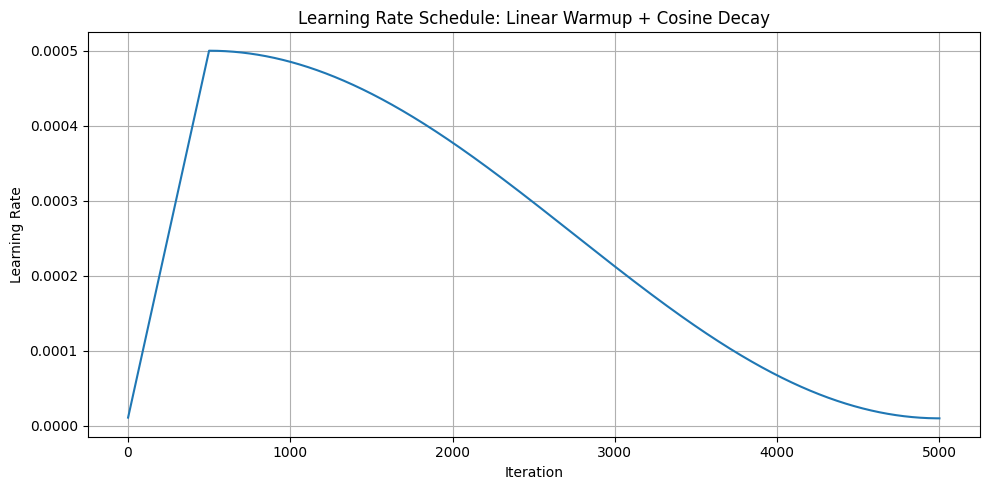

In [28]:
# Example
import matplotlib.pyplot as plt

# Scheduler configuration
n_iters = 5000
warmup_iters = 500
min_lr = 1e-5
max_lr = 5e-4

# Learning rate scheduler function
def get_lr(it):
    if it < warmup_iters:
        return min_lr + (max_lr - min_lr) * (it / warmup_iters)
    elif it <= n_iters:
        decay_iters = n_iters - warmup_iters
        it_decay = it - warmup_iters
        cosine_decay = 0.5 * (1 + math.cos(math.pi * it_decay / decay_iters))
        return min_lr + (max_lr - min_lr) * cosine_decay
    else:
        return min_lr

# Generate learning rate values
lr_values = [get_lr(it) for it in range(1, n_iters + 1)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_iters + 1), lr_values)
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule: Linear Warmup + Cosine Decay")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
n_iters = 5000

In [30]:
# Vanilla Attention
vocab_size = VANILLA_GPT_CONFIG["vocab_size"]
warmup_iters = 0.05*n_iters # 5% of total iterations
min_lr = VANILLA_GPT_CONFIG["lr"]
max_lr = VANILLA_GPT_CONFIG["lr"]*50
step = n_iters/50
start_time = time.time()  # Start timer

for iteration in range(1, n_iters + 1):
    lr = get_lr(iteration)
    for param_group in optimizer_vanilla.param_groups:
        param_group['lr'] = lr

    xb, yb = get_batch('train', VANILLA_GPT_CONFIG["batch_size"], VANILLA_GPT_CONFIG["context_length"])
    logits, loss = model_vanilla(x=xb, targets=yb, use_mask=VANILLA_GPT_CONFIG["use_mask"], pad_token_id=vocab_size)
    
    optimizer_vanilla.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_vanilla.step()

    if iteration % step == 0:
        print(f"Iteration {iteration}/{n_iters} | Loss: {loss.item():.4f}")

print("-----------------Training complete------------------")

end_time = time.time()  # End timer
total_time = end_time - start_time
print(f"\n✅ Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


Iteration 100/5000 | Loss: 5.2917
Iteration 200/5000 | Loss: 3.8963
Iteration 300/5000 | Loss: 3.6796
Iteration 400/5000 | Loss: 3.1347
Iteration 500/5000 | Loss: 3.1067
Iteration 600/5000 | Loss: 2.7305
Iteration 700/5000 | Loss: 2.8511
Iteration 800/5000 | Loss: 2.4496
Iteration 900/5000 | Loss: 2.2706
Iteration 1000/5000 | Loss: 2.2077
Iteration 1100/5000 | Loss: 1.9044
Iteration 1200/5000 | Loss: 1.9434
Iteration 1300/5000 | Loss: 2.0527
Iteration 1400/5000 | Loss: 1.6342
Iteration 1500/5000 | Loss: 1.6801
Iteration 1600/5000 | Loss: 1.4397
Iteration 1700/5000 | Loss: 1.2456
Iteration 1800/5000 | Loss: 1.2669
Iteration 1900/5000 | Loss: 1.0982
Iteration 2000/5000 | Loss: 0.9604
Iteration 2100/5000 | Loss: 1.1699
Iteration 2200/5000 | Loss: 0.8310
Iteration 2300/5000 | Loss: 0.8971
Iteration 2400/5000 | Loss: 0.9164
Iteration 2500/5000 | Loss: 0.7244
Iteration 2600/5000 | Loss: 0.5936
Iteration 2700/5000 | Loss: 0.6311
Iteration 2800/5000 | Loss: 0.6994
Iteration 2900/5000 | Loss: 0

In [31]:
# Headwise sharing Linear Attention
vocab_size = HW_LINEAR_GPT_CONFIG["vocab_size"]
warmup_iters = 0.05*n_iters # 5% of total iterations
min_lr = HW_LINEAR_GPT_CONFIG["lr"]
max_lr = HW_LINEAR_GPT_CONFIG["lr"]*50
step = n_iters/50
start_time = time.time()  # Start timer

for iteration in range(1, n_iters + 1):
    lr = get_lr(iteration)
    for param_group in optimizer_linear_hw.param_groups:
        param_group['lr'] = lr

    xb, yb = get_batch('train', HW_LINEAR_GPT_CONFIG["batch_size"], HW_LINEAR_GPT_CONFIG["context_length"])
    logits, loss = model_linear_hw(x=xb, targets=yb, use_mask=HW_LINEAR_GPT_CONFIG["use_mask"], pad_token_id=vocab_size)
    
    optimizer_linear_hw.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_linear_hw.step()

    if iteration % step == 0:
        print(f"Iteration {iteration}/{n_iters} | Loss: {loss.item():.4f}")

print("-----------------Training complete------------------")

end_time = time.time()  # End timer
total_time = end_time - start_time
print(f"\n✅ Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


Iteration 100/5000 | Loss: 5.3127
Iteration 200/5000 | Loss: 3.9249
Iteration 300/5000 | Loss: 3.7367
Iteration 400/5000 | Loss: 3.3106
Iteration 500/5000 | Loss: 3.5060
Iteration 600/5000 | Loss: 3.0930
Iteration 700/5000 | Loss: 3.0245
Iteration 800/5000 | Loss: 3.0114
Iteration 900/5000 | Loss: 2.6950
Iteration 1000/5000 | Loss: 2.6229
Iteration 1100/5000 | Loss: 2.3081
Iteration 1200/5000 | Loss: 2.6471
Iteration 1300/5000 | Loss: 2.8862
Iteration 1400/5000 | Loss: 2.4415
Iteration 1500/5000 | Loss: 2.6701
Iteration 1600/5000 | Loss: 2.1302
Iteration 1700/5000 | Loss: 2.2984
Iteration 1800/5000 | Loss: 2.2124
Iteration 1900/5000 | Loss: 2.3104
Iteration 2000/5000 | Loss: 1.9323
Iteration 2100/5000 | Loss: 2.1690
Iteration 2200/5000 | Loss: 2.1865
Iteration 2300/5000 | Loss: 1.9351
Iteration 2400/5000 | Loss: 2.0313
Iteration 2500/5000 | Loss: 1.8116
Iteration 2600/5000 | Loss: 1.8014
Iteration 2700/5000 | Loss: 1.7885
Iteration 2800/5000 | Loss: 1.5939
Iteration 2900/5000 | Loss: 1

In [32]:
# Layewise sharing Linear Attention
vocab_size = LW_LINEAR_GPT_CONFIG["vocab_size"]
warmup_iters = 0.05*n_iters # 5% of total iterations
min_lr = LW_LINEAR_GPT_CONFIG["lr"]
max_lr = LW_LINEAR_GPT_CONFIG["lr"]*50
step = n_iters/50
start_time = time.time()  # Start timer

for iteration in range(1, n_iters + 1):
    lr = get_lr(iteration)
    for param_group in optimizer_linear_lw.param_groups:
        param_group['lr'] = lr

    xb, yb = get_batch('train', LW_LINEAR_GPT_CONFIG["batch_size"], LW_LINEAR_GPT_CONFIG["context_length"])
    logits, loss = model_linear_lw(x=xb, targets=yb, use_mask=LW_LINEAR_GPT_CONFIG["use_mask"], pad_token_id=vocab_size)
    
    optimizer_linear_lw.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_linear_lw.step()

    if iteration % step == 0:
        print(f"Iteration {iteration}/{n_iters} | Loss: {loss.item():.4f}")

print("-----------------Training complete------------------")

end_time = time.time()  # End timer
total_time = end_time - start_time
print(f"\n✅ Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


Iteration 100/5000 | Loss: 5.3728
Iteration 200/5000 | Loss: 4.0144
Iteration 300/5000 | Loss: 3.9900
Iteration 400/5000 | Loss: 3.3430
Iteration 500/5000 | Loss: 3.2002
Iteration 600/5000 | Loss: 2.6867
Iteration 700/5000 | Loss: 2.7301
Iteration 800/5000 | Loss: 2.3447
Iteration 900/5000 | Loss: 2.3574
Iteration 1000/5000 | Loss: 2.1127
Iteration 1100/5000 | Loss: 2.1073
Iteration 1200/5000 | Loss: 1.9609
Iteration 1300/5000 | Loss: 1.7440
Iteration 1400/5000 | Loss: 1.8616
Iteration 1500/5000 | Loss: 1.7131
Iteration 1600/5000 | Loss: 1.5495
Iteration 1700/5000 | Loss: 1.5189
Iteration 1800/5000 | Loss: 1.4707
Iteration 1900/5000 | Loss: 1.3128
Iteration 2000/5000 | Loss: 1.4725
Iteration 2100/5000 | Loss: 1.2588
Iteration 2200/5000 | Loss: 1.2113
Iteration 2300/5000 | Loss: 1.0747
Iteration 2400/5000 | Loss: 1.1662
Iteration 2500/5000 | Loss: 1.1410
Iteration 2600/5000 | Loss: 1.1140
Iteration 2700/5000 | Loss: 1.0388
Iteration 2800/5000 | Loss: 1.0652
Iteration 2900/5000 | Loss: 1

In [33]:
# Key value sharing Linear Attention
vocab_size = KV_LINEAR_GPT_CONFIG["vocab_size"]
warmup_iters = 0.05*n_iters # 5% of total iterations
min_lr = KV_LINEAR_GPT_CONFIG["lr"]
max_lr = KV_LINEAR_GPT_CONFIG["lr"]*50
step = n_iters/50
start_time = time.time()  # Start timer

for iteration in range(1, n_iters + 1):
    lr = get_lr(iteration)
    for param_group in optimizer_linear_kv.param_groups:
        param_group['lr'] = lr

    xb, yb = get_batch('train', KV_LINEAR_GPT_CONFIG["batch_size"], KV_LINEAR_GPT_CONFIG["context_length"])
    logits, loss = model_linear_kv(x=xb, targets=yb, use_mask=KV_LINEAR_GPT_CONFIG["use_mask"], pad_token_id=vocab_size)
    
    optimizer_linear_kv.zero_grad(set_to_none=True)
    loss.backward()
    optimizer_linear_kv.step()

    if iteration % step == 0:
        print(f"Iteration {iteration}/{n_iters} | Loss: {loss.item():.4f}")

print("-----------------Training complete------------------")

end_time = time.time()  # End timer
total_time = end_time - start_time
print(f"\n✅ Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


Iteration 100/5000 | Loss: 5.0921
Iteration 200/5000 | Loss: 4.1774
Iteration 300/5000 | Loss: 3.7518
Iteration 400/5000 | Loss: 3.1756
Iteration 500/5000 | Loss: 3.4340
Iteration 600/5000 | Loss: 3.4934
Iteration 700/5000 | Loss: 3.5988
Iteration 800/5000 | Loss: 3.2046
Iteration 900/5000 | Loss: 2.7613
Iteration 1000/5000 | Loss: 3.1318
Iteration 1100/5000 | Loss: 2.4563
Iteration 1200/5000 | Loss: 2.9280
Iteration 1300/5000 | Loss: 2.5529
Iteration 1400/5000 | Loss: 2.6728
Iteration 1500/5000 | Loss: 2.2650
Iteration 1600/5000 | Loss: 2.3254
Iteration 1700/5000 | Loss: 2.0403
Iteration 1800/5000 | Loss: 2.2335
Iteration 1900/5000 | Loss: 2.1815
Iteration 2000/5000 | Loss: 2.2008
Iteration 2100/5000 | Loss: 2.1846
Iteration 2200/5000 | Loss: 1.9591
Iteration 2300/5000 | Loss: 2.3381
Iteration 2400/5000 | Loss: 2.0743
Iteration 2500/5000 | Loss: 1.7710
Iteration 2600/5000 | Loss: 2.0327
Iteration 2700/5000 | Loss: 1.7633
Iteration 2800/5000 | Loss: 1.7569
Iteration 2900/5000 | Loss: 1